In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [8]:
train_path = r"E:\Documents\My Progects\Filtr\Data\Images\Train"
test_path = r"E:\Documents\My Progects\Filtr\Data\Images\Test"
valid_path = r"E:\Documents\My Progects\Filtr\Data\Images\valid"
datagen = ImageDataGenerator()

In [ ]:
with os.scandir(test_path) as dir:
    for img in dir:
        print(img)

## ImageDataGenerator class

Keras has this ImageDataGenerator class which allows the users to perform image augmentation on the fly in a very easy way. You can read about that in Keras’s official documentation.

Most of the Image datasets that I found online has 2 common formats, the first common format contains all the images within separate folders named after their respective class names, This is by far the most common format I always see online and Keras allows anyone to utilize the flow_from_directory function to easily the images read from the disc and perform powerful on the fly image augmentation with the ImageDataGenerator.

The second most common format I found online is, all the images are present inside a single directory and their respective classes are mapped in a CSV or JSON file, but Keras doesn’t support this earlier and one would have to move the images to separate directories with their respective classes names or write a custom generator to handle this case, So I have written a function flow_from_dataframe that recently got accepted to the official keras-preprocessing git repo, that allows you to input a Pandas dataframe which contains the filenames(with or without the extensions) column and a column which has the class names and directly read the images from the directory with their respective class names mapped.

[Heres a link to how to use flow_from_dataframe](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)

[ImageDataGenerator methods](https://medium.com/datadriveninvestor/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92)

The ImageDataGenerator class has three methods flow(), flow_from_directory() and flow_from_dataframe() to read the images from a big numpy array and folders containing images.
![](https://miro.medium.com/max/1400/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

As you can see in the above picture, the test folder should also contain a single folder inside which all the test images are present(Think of it as “unlabeled” class , this is there because the flow_from_directory() expects at least one directory under the given directory path).

The folder names for the classes are important, name(or rename) them with respective label names so that it would be easy for you later.

#### Here are the most used attributes along with the flow_from_directory() method.
```python
train_generator = train_datagen.flow_from_directory(
    directory=r"./train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
```

* __directory__ must be set to the path where your ‘n’ classes of folders are present.
*  __target_size__ is the size of your input images, every image will be resized to this size.
* __color_mode__: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.
* __batch_size__: No. of images to be yielded from the generator per batch.
* __class_mode__: Set “binary” if you have only two classes to predict, if not set to“categorical”, in case if you’re developing an Autoencoder system, both input and the   output would probably be the same image, for this case set to “input”.
* __shuffle__: Set True if you want to shuffle the order of the image that is being yielded, else set False.
* __seed__: Random seed for applying random image augmentation and shuffling the order of the image.



In [9]:
train_batches = datagen.flow_from_directory(train_path,target_size=(224,224),color_mode="rgb",batch_size=32,class_mode='binary',shuffle=True,seed=42)
valid_batches = datagen.flow_from_directory(valid_path,target_size=(224,224),color_mode="rgb",batch_size=12,class_mode='binary',shuffle=True,seed=42)
test_batches = datagen.flow_from_directory(test_path,target_size=(224,224),color_mode="rgb",batch_size=1,class_mode='binary',shuffle=True,seed=42)

Found 4207 images belonging to 2 classes.
Found 1536 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [10]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [11]:
imgs,labels = next(train_batches)

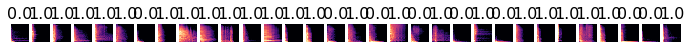

In [12]:
plots(imgs,titles=labels)

# Building a CNN Model

In [ ]:
# set up CNN Model
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(256,256,3)))
#model.add(Conv2D(96,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

#model.add(Conv2D(128,(3,3)))
model.add(Conv2D(256,(3,3)))
model.add(Activation("relu"))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256,(3,3)))
model.add(Activation("relu"))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# output layer has 2 neurons since were predicting 2 classes
model.add(Dense(1))
model.add(Activation("softmax"))

model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ["accuracy"])

model.summary()

# Fine tuning a VGG16 pretrained model

In [13]:
vgg16 = keras.applications.vgg16.VGG16()

In [14]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
type(vgg16)

In [15]:
# turning the vgg model into a sequential model
model = Sequential()
# iterate over all the layers (except for the last one) in the vgg16 model
# taking off the output layer so we can later re-add it with the amount of classes we need
for layer in vgg16.layers[:-1]:
    model.add(layer)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [17]:
# this sets all the layers to be non trainable so that the weights will stay the same 
# which is what we want in the case of fine tuning
for layer in model.layers:
    layer.trainable = False
    

In [18]:
# add the output dense layer
model.add(Dense(1,activation="softmax"))
model.add(BatchNormalization())

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [20]:
model.compile(Adam(lr=.0001),
              loss = 'binary_crossentropy',
             metrics = ["accuracy"])

In [21]:
# we have to use model.fit_generator since we preprocessed the training data with a generator
model.fit_generator(train_batches,validation_data=valid_batches,epochs=5,verbose=True)

Epoch 1/5
132/132 [==============================] - 1914s 14s/step - loss: 7.3553 - accuracy: 0.5237 - val_loss: 0.6794 - val_accuracy: 0.5625
Epoch 2/5
132/132 [==============================] - 1271s 10s/step - loss: 7.3553 - accuracy: 0.5237 - val_loss: 0.9054 - val_accuracy: 0.4375
Epoch 3/5
132/132 [==============================] - 1243s 9s/step - loss: 7.3553 - accuracy: 0.5237 - val_loss: 0.9234 - val_accuracy: 0.4375
Epoch 4/5


KeyboardInterrupt: 

In [ ]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs,titles=test_labels)